In [1]:
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download("stopwords")
import os
import time
import matplotlib.pyplot as plt
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import numpy as np
from IPython.display import clear_output
import math
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from statistics import mean
from collections import OrderedDict
import itertools

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kyoto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kyoto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
FREQUENCY_LIMIT = 10
TIME_ROUND = 2

removingPOS = [
            'NUMR',
            'NPRO',
            'PREP',
            'CONJ',
            'PRCL',
            'INTJ',
            'None'
        ]

dataset_train_file = 'dataset/train.json'
dataset_test_file = 'dataset/test.json'

seed = 42

In [3]:
def time_stamp(message=False, start_time=None):
    if message != False:
        time_ = round(time.time() - start_time, TIME_ROUND)
        print(f"{message} {time_} s")    
    
    return time.time() 

In [4]:
train = json.load(open(dataset_train_file, "r", encoding="utf8"))
test = json.load(open(dataset_test_file, "r", encoding="utf8"))

In [4]:
print("train lenght: ", len(train))
print("test lenght: ", len(test))

train lenght:  8263
test lenght:  2056


In [5]:
print("train columns: ", list(train[0].keys()))
print("test columns: ", list(test[0].keys()))

train columns:  ['text', 'id', 'sentiment']
test columns:  ['text', 'id']


In [6]:
print('classes: ', set([n['sentiment'] for n in train]))

classes:  {'neutral', 'positive', 'negative'}


In [5]:
train_texts = [item["text"] for item in train]
test_texts = [item["text"] for item in test]

### Preprocessing

In [5]:
def get_normal_form(tokens):
    for i in range(len(tokens)):
        tokens[i] = morph.parse(tokens[i])[0].normal_form
                
    return tokens

In [6]:
russian_stopwords = set(stopwords.words("russian"))

def remove_stopwords(tokens):
    text_without_stopwords = []
    for token in tokens:
        if token not in russian_stopwords:
            text_without_stopwords.append(token)
            
    return text_without_stopwords

In [7]:
def remove_POS(tokens, PoSList, add_pos_in_token):
    text_without_pos = []
    PoSList = set(PoSList)
    for token in tokens:
        pos = str(morph.parse(token)[0].tag.POS)
        if pos not in PoSList:        
            if add_pos_in_token == True:
                text_without_pos.append(token+'_'+pos)
            else:
                text_without_pos.append(token)
    
    return text_without_pos

In [8]:
def get_word_freq(clean_text):
    wordFreq = {}
    for tokensList in clean_text:
        for token in tokensList:
            wordFreq[token] = wordFreq.get(token, 0) + 1
        
    return wordFreq

In [9]:
def remove_low_freq(tokens, freqDict, freqLimit):
    text_without_low_freq = []
    for token in tokens:
        if freqDict[token] >= freqLimit:
            text_without_low_freq.append(token)       
    
    return text_without_low_freq

In [10]:
def get_dictionary(textsList):
    dictionary = set()
    for text in textsList:
        for token in text:            
            dictionary.add(token)
    
    return list(dictionary)

In [11]:
# Функция для очистки текста
# Если add_pos_in_token==true, к каждому токену будет добавлена его часть речи в формате word2vec модели
# data - массив строк
# возвращает двумерный массив токенов
def preprocess(data, removingPOS, add_pos_in_token=False):    
    time_start = time_stamp()
    
    clean_texts = []   # Список для хранения текстов после обработки    
    t = 0
    
    for item in data:         
        text = item
        
        # Токенизация текста с помощью токенизатора NLTK
        text = word_tokenize(text)  
        
        # Приведение слов к нормальной форме
        text = get_normal_form(text) 
        
        # Удаление из текста стоп-слов, полученных из набора NLTK
        text = remove_stopwords(text)   
        
        # Удаление из текста слов, имеющих части речи из removingPOS
        # Если add_pos_in_token==true добавляет часть речи к каждому токену
        text = remove_POS(text, removingPOS, add_pos_in_token)    
        
        clean_texts.append(text)        
        
        t += 1                  
        clear_output(wait=True)
        print("texts cleaned:", t)   # Обновление количества обработанных текстов
    
    time_start = time_stamp("texts cleaned in", time_start)
            
            
    return clean_texts

In [12]:
def make_dict(clean_texts, freq_limit):
    time_start = time_stamp()
    # Создание словаря частот слов в корпусе
    freq_dict = get_word_freq(clean_texts)   

    # Удаление из текстов слов, имеющих частоту меньше заданной в freqLimit
    for i in range(len(clean_texts)): 
        clean_texts[i] = remove_low_freq(clean_texts[i], freq_dict, freq_limit)   

    # Создание словаря корпуса
    main_dict = get_dictionary(clean_texts)

    time_stamp("dictionary generated in", time_start)

    return main_dict

In [51]:
clean_texts_train = preprocess(train_texts[:50], removingPOS, add_pos_in_token=False)

texts cleaned: 50
texts cleaned in 7.15 s


In [52]:
dict_train = make_dict(clean_texts_train, 10)

dictionary generated in 0.01 s


In [53]:
clean_texts_train_pos = preprocess(train_texts[:50], removingPOS, add_pos_in_token=True)

texts cleaned: 50
texts cleaned in 7.21 s


In [54]:
dict_train_pos = make_dict(clean_texts_train_pos, 10)

dictionary generated in 0.0 s


### bool vectorizer

In [13]:
# Создание булевской матрицы термин-документ
def create_bool_matrix(clean_texts, main_dict):
    time_start = time_stamp()
    matrix = []
    count = 0
    for text in clean_texts:
        matrix.append([])
        text_set = set(text)
        for dictToken in main_dict:
            if dictToken in text_set:
                matrix[count].append(1)
            else:
                matrix[count].append(0)
        count += 1
    
    time_stamp("matrix generated in", time_start)
    
    return np.asarray(matrix)

In [55]:
X_train = create_bool_matrix(clean_texts_train, dict_train)

matrix generated in 0.0 s


In [56]:
print(X_train.shape)

(50, 229)


In [57]:
X_train

array([[1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])

### Tfidf vectorizer

In [13]:
def create_tfidf_matrix(clean_texts, mainDict):
    
    time_start = time_stamp()
    IDFweights = {}
    N = len(clean_texts)
    clean_texts_set = [set(text) for text in clean_texts]  # перевод списков токенов в множества
    
    # IDF = log(N/df)+1, N - общее число документов, 
    # df - количество документов в которых присутствует токен
    for token in mainDict:
        df = 0
        for text in clean_texts_set:
            if token in text:
                df += 1
        
        N+=1
        df+=1 
        IDFweights[token] = math.log(N/df)+1
    
    time_stamp("idf calculated in", time_start)  
    
    start_time = time_stamp()
    matrix = []
    count = 0
    
    # TF = количество вхождений слова в тексте
    for i in range(len(clean_texts)):
        matrix.append([])
        for dictToken in IDFweights.keys(): 
            if dictToken in clean_texts_set[i]:
                numEntries = clean_texts[i].count(dictToken)
                TF = numEntries              
                matrix[count].append(IDFweights[dictToken]*TF)
            else:
                matrix[count].append(0)
        
        count += 1
            
    start_time = time_stamp("matrix generated in", start_time)
    
    # L2-нормализация
    for i in range(len(matrix)):
        root = pow(sum([pow(t,2) for t in matrix[i]]), 0.5)
        for j in range(len(matrix[i])):
            matrix[i][j] = matrix[i][j] / root
            
    
    time_stamp("matrix normalized in", start_time)
    return np.asarray(matrix)

In [58]:
X_train = create_tfidf_matrix(clean_texts_train, dict_train)

idf calculated in 0.0 s
matrix generated in 0.01 s
matrix normalized in 0.0 s


In [59]:
print(X_train.shape)

(50, 229)


In [60]:
X_train

array([[0.07107503, 0.        , 0.        , ..., 0.12582972, 0.        ,
        0.        ],
       [0.05747282, 0.        , 0.        , ..., 0.2034973 , 0.22211348,
        0.12131054],
       [0.00970892, 0.01081237, 0.        , ..., 0.        , 0.01876089,
        0.        ],
       ...,
       [0.        , 0.        , 0.31244436, ..., 0.        , 0.        ,
        0.        ],
       [0.05650274, 0.        , 0.        , ..., 0.        , 0.21836443,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.09544978, 0.        ,
        0.        ]])

### Word2Vec vectorizer

In [15]:
# Создание матрицы w2v весов документов
def create_w2v_matrix(clean_texts, mainDict, wvModel):
    time_start = time_stamp()    
    wvDict = {}
    for token in mainDict:
        if token in wvModel:
            wvDict[token] = wvModel[token]
    time_stamp("w2v dictionary created in", time_start)
    
    time_start = time_stamp()
    dimention = len(list(wvDict.values())[0]) # Размерность векторов эмбеддингов
    matrix = []
    count = 0 # Текущий документ
    word_count = 0 # Количество закодированных токенов в документе
    
    for text in clean_texts:
        matrix.append([0]*dimention)
        word_count = 0
        for token in text:
            if token in wvDict.keys():
                word_count += 1
                for i in range(dimention):
                    # Суммирование векторов эмбеддингов по каждому токену в документе
                    matrix[count][i] += wvDict[token][i]  
        
        if word_count > 0: # Если нашелся хотя бы один эмбеддинг
            for i in range(dimention):
                        # Усреднение полученных эмбеддингов
                        matrix[count][i] /= word_count 
        count += 1
            
    time_stamp("w2v matrix created in", time_start)    
    return np.asarray(matrix)

In [16]:
model_folder = "models/"
rus_model_name = model_folder + 'ruscorpora_1_300_10.bin' # ruscorpora_upos_skipgram_300_10_2017
if '.vec' in rus_model_name:
    binary = False
else:
    binary = True
    
rus_model = KeyedVectors.load_word2vec_format(rus_model_name, binary=binary)

In [63]:
X_train = create_w2v_matrix(clean_texts_train_pos, dict_train_pos, rus_model)

w2v dictionary created in 0.0 s
w2v matrix created in 0.3 s


In [64]:
print(X_train.shape)

(50, 300)


In [65]:
X_train

array([[ 0.03324771, -0.02306858, -0.03816256, ...,  0.01351737,
        -0.04157148, -0.01139542],
       [ 0.01567918,  0.00398735, -0.02170607, ...,  0.02240999,
        -0.02909771, -0.03169704],
       [ 0.02340538, -0.00556218,  0.01419174, ..., -0.00949234,
        -0.03832603, -0.00598095],
       ...,
       [ 0.01051688, -0.01538863, -0.01017525, ..., -0.00969697,
        -0.08690896, -0.01435089],
       [ 0.02285083, -0.00335514, -0.02039825, ...,  0.02307726,
        -0.03212652, -0.02646495],
       [ 0.02635533, -0.02312358, -0.01665819, ...,  0.01505917,
        -0.07514472, -0.01527469]])

In [14]:
def save_as_json(data, filename, indent):
    with open(filename, 'w', encoding='utf8') as outfile:
        json.dump(data, outfile, indent=indent, ensure_ascii=False)

In [15]:
def load_json(filename):
    with open(filename, 'r', encoding='utf8') as json_file:
        data = json.load(json_file)
    return data

In [16]:
def save_as_sparse(data, filename):
    csr = csr_matrix(data)
    save_npz(filename, csr)

In [17]:
def load_sparse(filename):
    csr = load_npz(filename)
    dense = csr.todense()
    return dense

#### Предобработка обучающего корпуса

In [18]:
# Файлы с обработанным текстом (без кодирования)
clean_texts_train_file = "clean/train.json"
clean_texts_pos_train_file = "clean/train_pos.json"

clean_texts_test_file = "clean/test.json"
clean_texts_pos_test_file ="clean/test_pos.json"


In [19]:
removingPOS = [
            'NUMR',
            'NPRO',
            'PREP',
            'CONJ',
            'PRCL',
            'INTJ',
            'None'
        ]

In [86]:
train_texts = [item["text"] for item in train]
test_texts = [item["text"] for item in test]

In [80]:
clean_texts_train = preprocess(train_texts, removingPOS, add_pos_in_token=False)
save_as_json(clean_texts_train, clean_texts_train_file, indent=0)

In [81]:
clean_texts_train_pos = preprocess(train_texts, removingPOS, add_pos_in_token=True)
save_as_json(clean_texts_train_pos, clean_texts_pos_train_file, indent=0)

texts cleaned: 8263
texts cleaned in 2025.71 s


In [88]:
clean_texts_test = preprocess(test_texts, removingPOS, add_pos_in_token=False)
save_as_json(clean_texts_test, clean_texts_test_file, indent=0)

texts cleaned: 2056
texts cleaned in 474.18 s


In [89]:
clean_texts_test_pos = preprocess(test_texts, removingPOS, add_pos_in_token=True)
save_as_json(clean_texts_test_pos, clean_texts_pos_test_file, indent=0)

texts cleaned: 2056
texts cleaned in 460.22 s


#### Оценка классификаторов

In [20]:
FREQUENCY_LIMIT = 40

# Названия полей в словаре с результатами
RESULTS_SCORE = "Score"
RESULTS_TIME = "Time"

# Параметры нейронной сети
BATCH_SIZE = 300
HIDDEN_SIZE = 1000
NUM_CLASSES = 3
NUM_EPOCH = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Округление результатов
TIME_ROUND = 2
SCORE_ROUND = 3

# Файлы с результатами
results_bool_file = "results/bool.json"
results_tfidf_file = "results/tfidf.json"
results_w2v_file = "results/w2v.json"

In [22]:
classes = ['positive', 'negative', 'neutral']

# Представление классов для нейронной сети в виде [1,0,0]=postive [0,1,0]=negative [0,0,1]=neutral
def class_names_to_digits(data):
    labels = []    
    count = 0
    for item in data:
        labels.append([0,0,0])
        labels[count][classes.index(item)] = 1        
        count += 1
        #labels.append(classes.index(item))
    return np.asarray(labels)

def digits_to_class_names(indeces):
    labels = []
    for i in indeces:
        labels.append(classes[i.index(max(i))])
    return labels

In [23]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super().__init__()
        self.linear_1 = torch.nn.Linear(input_size, hidden_size)
        self.linear_2 = torch.nn.Linear(hidden_size, num_classes)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = torch.relu(self.linear_1(x))
        logits = self.linear_2(x)
        probs = self.sm(logits)
        return probs

In [24]:
def train_loop(data_loader, model, loss_fn, optimizer):
    model.train()
    for i, (texts, labels) in enumerate(data_loader):
        
        texts = texts.to(device)
        labels = labels.to(device)
        
        predicts = model(texts)  
        
        loss = loss_fn(predicts, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        #if i % 10 == 0:
            #print(f'loss: {loss}')

In [25]:
def evaluate_classifiers(clean_texts, labels, cv, classifiers, vectorize_function, w2v_model=None):   
    # Создание словаря, в который будут записаны результаты    
    results = {name: {RESULTS_SCORE:0, RESULTS_TIME:0} for name in classifiers}
    results["Neural Network"] = {RESULTS_SCORE:0, RESULTS_TIME:0}
    
    # Информация о ходе работы
    step_n = 1  
    steps_max = cv*(len(results)+1)
    
    full_time_start = time.time()
    
    # Разбиение текстов для кросс-валидации
    skf = StratifiedKFold(n_splits=cv, random_state=seed, shuffle=True)
        
    for train_indeces, test_indeces in skf.split(clean_texts, labels):
                
        train_texts = [clean_texts[i] for i in train_indeces]
        train_labels = [labels[i] for i in train_indeces]
        
        test_texts = [clean_texts[i] for i in test_indeces]
        test_labels = [labels[i] for i in test_indeces]
        
        # Получение словаря для текущего разбиения
        dict_ = make_dict(train_texts, FREQUENCY_LIMIT)
        
        # Кодирование train и test
        if w2v_model == None:
            train_vect = vectorize_function(train_texts, dict_)
            test_vect = vectorize_function(test_texts, dict_)
        else:
            train_vect = vectorize_function(train_texts, dict_, w2v_model)
            test_vect = vectorize_function(test_texts, dict_, w2v_model)
    
        # Обучение и оценка классификаторов
        for key in classifiers: 
            
            # NB классификаторы не поддерживают отрицательные значения признаков, которые содержит w2v матрица
            if w2v_model != None and (key == "GaussianNB" or key == "MultinomialNB"):
                results[key][RESULTS_SCORE] += 0
                results[key][RESULTS_TIME] += 0
                continue
            
            print(f"step {step_n}/{steps_max}")
            step_n += 1
            
            start_time = time.time()
            clf = classifiers[key].fit(train_vect, train_labels)
            time_ = time.time() - start_time
            
            predictions = clf.predict(test_vect)
            score = f1_score(test_labels, predictions, average='macro')
            
            results[key][RESULTS_SCORE] += score
            results[key][RESULTS_TIME] += time_
    
        torch.manual_seed(seed)
        
        # Создание датасетов для нейронной сети по текущему разбиению
        train_ = TensorDataset(torch.tensor(train_vect.astype(np.float32)), 
                               torch.tensor(class_names_to_digits(train_labels).astype(np.float32)))        
        train_loader = DataLoader(train_, batch_size=BATCH_SIZE, shuffle=True)
        
        test_ = TensorDataset(torch.tensor(test_vect.astype(np.float32)), 
                               torch.tensor(class_names_to_digits(test_labels).astype(np.float32)))        
        test_loader = DataLoader(test_, batch_size=BATCH_SIZE, shuffle=True)
               
        
        input_size = train_vect.shape[1]
        
        # Создание нейронной сети
        model = NeuralNetwork(input_size, NUM_CLASSES, HIDDEN_SIZE)
        model.to(device)
        
        loss_fn = nn.BCELoss()
        learning_rate = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        print(f"step {step_n}/{steps_max}")
        step_n += 1
        
        start_time = time.time()
        # Обучение нейронной сети        
        for t in range(NUM_EPOCH):
            train_loop(train_loader, model, loss_fn, optimizer)
        time_ = time.time() - start_time
        
        # Оценка нейронной сети
        labels_list = []
        predicted_list = []        
        with torch.no_grad():
            model.eval()
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                y_pred = model(X)
                labels_list += y
                predicted_list += y_pred
        
        for i in range(len(labels_list)):
            labels_list[i] = labels_list[i].cpu().numpy().tolist()
            predicted_list[i] = predicted_list[i].cpu().numpy().tolist()
        
        labels_list = digits_to_class_names(labels_list)
        predicted_list = digits_to_class_names(predicted_list)
                
        score = f1_score(labels_list, predicted_list, average='macro')
        
        results["Neural Network"][RESULTS_SCORE] += score
        results["Neural Network"][RESULTS_TIME] += time_
    
    # Получение средних значений для всех классификаторов
    for i in results:
        results[i][RESULTS_SCORE] /= cv
        results[i][RESULTS_TIME] /= cv
        results[i][RESULTS_SCORE] = round(results[i][RESULTS_SCORE], SCORE_ROUND)
        results[i][RESULTS_TIME] = round(results[i][RESULTS_TIME], TIME_ROUND)
    
    clear_output(wait=True)
    print(f"Overall time: {round((time.time()-full_time_start)/60, TIME_ROUND)} min")
    return results

In [26]:
classifiers = {
    "Logistic": LogisticRegression(random_state=seed, max_iter=1000),
    "Ridge": RidgeClassifier(random_state=seed),
    "SVM linear": SVC(random_state=seed, kernel='linear'),
    "SVM rbf": SVC(random_state=seed, kernel='rbf'),
    "SVM poly": SVC(random_state=seed, kernel='poly'),
    "SVM sigmoid": SVC(random_state=seed, kernel='sigmoid'),
    "KNeighbors": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "AdaBoost": AdaBoostClassifier(random_state=seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=seed),  
}

In [29]:
train_labels = [item["sentiment"] for item in train]

In [36]:
# Получение результатов для бинарного векторизатора
clean_texts_train = load_json(clean_texts_train_file)
results_bool = evaluate_classifiers(clean_texts_train, train_labels, 5, classifiers, create_bool_matrix)
save_as_json(results_bool, results_bool_file, indent=2)

Overall time: 109.19 min


In [39]:
# Получение результатов для tfidf векторизатора
clean_texts_train = load_json(clean_texts_train_file)
results_tfidf = evaluate_classifiers(clean_texts_train, train_labels, 5, classifiers, create_tfidf_matrix)
save_as_json(results_tfidf, results_tfidf_file, indent=2)

Overall time: 116.6 min


In [44]:
# Получение результатов для word2vec векторизатора
model_folder = "models/"
rus_model_name = model_folder + 'ruscorpora_1_300_10.bin' # ruscorpora_upos_skipgram_300_10_2017
if '.vec' in rus_model_name:
    binary = False
else:
    binary = True
    
rus_model = KeyedVectors.load_word2vec_format(rus_model_name, binary=binary)

clean_texts_train_pos = load_json(clean_texts_pos_train_file)
results_w2v = evaluate_classifiers(clean_texts_train_pos, train_labels, 5, classifiers, create_w2v_matrix, rus_model)
save_as_json(results_w2v, results_w2v_file, indent=2)

Overall time: 30.25 min


#### Вывод результатов тестирования

In [27]:
bool_results = load_json(results_bool_file)
tfidf_results = load_json(results_tfidf_file)
w2v_results = load_json(results_w2v_file)

In [32]:
print("All results (f1-score)")

d = {'bool': [bool_results[i][RESULTS_SCORE] for i in bool_results]+
             [round(mean([bool_results[i][RESULTS_SCORE] for i in bool_results]),3)], 
     
     'tfidf': [tfidf_results[i][RESULTS_SCORE] for i in tfidf_results]+
              [round(mean([tfidf_results[i][RESULTS_SCORE] for i in tfidf_results]),3)],
     
    'word2vec': [w2v_results[i][RESULTS_SCORE] for i in w2v_results]+
                [round(mean([w2v_results[i][RESULTS_SCORE] for i in w2v_results]),3)],     
     
    'average': [round((w2v_results[i][RESULTS_SCORE]+
                tfidf_results[i][RESULTS_SCORE]+
                bool_results[i][RESULTS_SCORE])/3,3) for i in bool_results]+[0]}

df = pd.DataFrame(data=d, index=list(bool_results.keys())+["average"])
df.sort_values(by=['average'], ascending=False)

All results (f1-score)


,bool,tfidf,word2vec,average
SVM rbf,0.670,0.701,0.613,0.661
Random Forest,0.654,0.653,0.621,0.643
Neural Network,0.674,0.687,0.566,0.642
Gradient Boosting,0.640,0.630,0.625,0.632
KNeighbors,0.557,0.671,0.645,0.624
Logistic,0.647,0.687,0.519,0.618
Ridge,0.589,0.692,0.563,0.615
SVM linear,0.617,0.698,0.441,0.585
SVM sigmoid,0.556,0.686,0.505,0.582
SVM poly,0.435,0.653,0.632,0.573


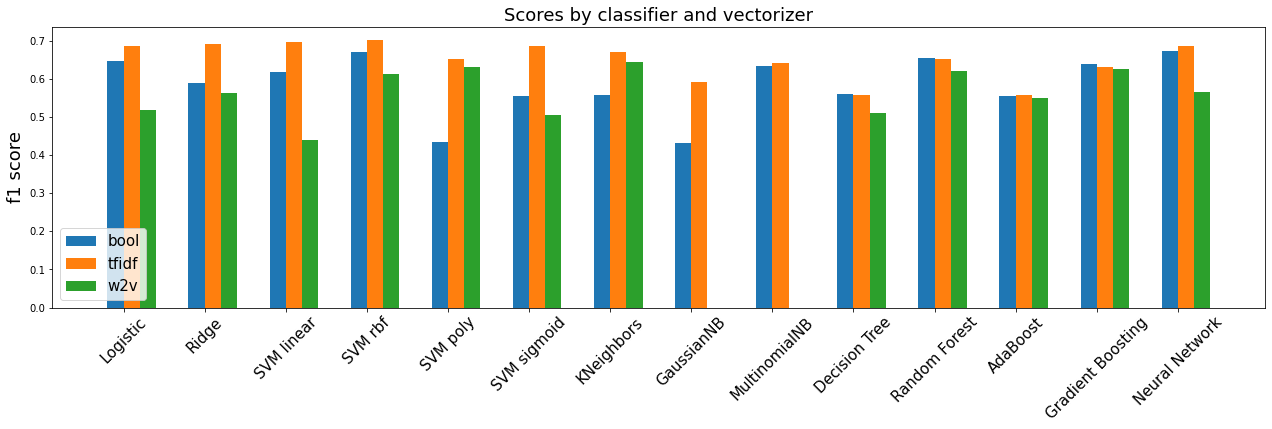

In [34]:
labels = list(bool_results.keys())
bool_ = [bool_results[i][RESULTS_SCORE] for i in bool_results]
tfidf_ = [tfidf_results[i][RESULTS_SCORE] for i in tfidf_results]
w2v_ = [w2v_results[i][RESULTS_SCORE] for i in w2v_results]

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bool_, width, label='bool')
rects2 = ax.bar(x + width/2, tfidf_, width, label='tfidf')
rects3 = ax.bar(x + width*1.5, w2v_, width, label='w2v')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('f1 score', fontsize=18)
ax.set_title('Scores by classifier and vectorizer', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15)
ax.legend(fontsize=15, loc="lower left")

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)

fig.tight_layout()
fig.set_size_inches(22, 5)

plt.xticks(rotation = 45)
plt.show()

In [74]:
print("All results (time, s)")

d = {'bool': [bool_results[i][RESULTS_TIME] for i in bool_results]+
             [round(mean([bool_results[i][RESULTS_TIME] for i in bool_results]),3)], 
     
     'tfidf': [tfidf_results[i][RESULTS_TIME] for i in tfidf_results]+
              [round(mean([tfidf_results[i][RESULTS_TIME] for i in tfidf_results]),3)],
     
    'word2vec': [w2v_results[i][RESULTS_TIME] for i in w2v_results]+
                [round(mean([w2v_results[i][RESULTS_TIME] for i in w2v_results]),3)],     
     
    'average': [round((w2v_results[i][RESULTS_TIME]+
                tfidf_results[i][RESULTS_TIME]+
                bool_results[i][RESULTS_TIME])/3,3) for i in bool_results]+[999]}

df = pd.DataFrame(data=d, index=list(bool_results.keys())+["average"])
df.sort_values(by=['average'], ascending=True)

All results (time, s)


,bool,tfidf,word2vec,average
KNeighbors,0.020,0.080,0.010,0.037
GaussianNB,0.490,0.550,0.000,0.347
MultinomialNB,1.060,0.080,0.000,0.380
Neural Network,2.960,2.660,0.750,2.123
Ridge,3.740,3.340,0.040,2.373
Logistic,15.830,4.330,0.460,6.873
Decision Tree,10.220,13.160,2.030,8.470
Random Forest,16.750,18.700,7.280,14.243
AdaBoost,44.120,48.710,11.070,34.633
SVM sigmoid,75.130,87.250,9.330,57.237


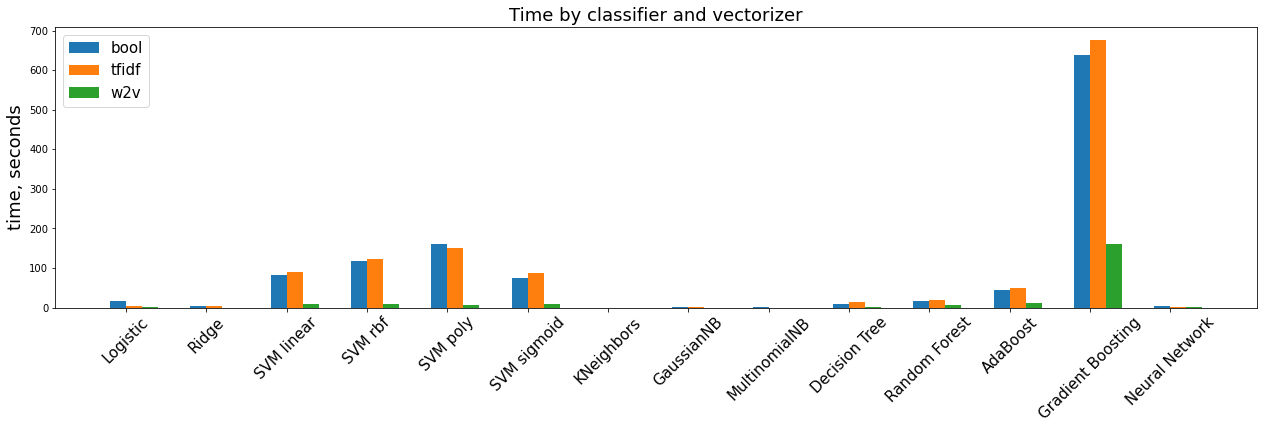

In [35]:
labels = list(bool_results.keys())
bool_ = [bool_results[i][RESULTS_TIME] for i in bool_results]
tfidf_ = [tfidf_results[i][RESULTS_TIME] for i in tfidf_results]
w2v_ = [w2v_results[i][RESULTS_TIME] for i in w2v_results]

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bool_, width, label='bool')
rects2 = ax.bar(x + width/2, tfidf_, width, label='tfidf')
rects3 = ax.bar(x + width*1.5, w2v_, width, label='w2v')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time, seconds', fontsize=18)
ax.set_title('Time by classifier and vectorizer', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15)
ax.legend(fontsize=15, loc="upper left")

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)

fig.tight_layout()
fig.set_size_inches(22, 5)

plt.xticks(rotation = 45)
plt.show()

In [31]:
top_n = 10

summary = {}
for key in bool_results:
    summary["bool + "+key] = bool_results[key]
    summary["tfidf + "+key] = tfidf_results[key]
    summary["w2v + "+key] = w2v_results[key]
    
sorted_tuples = sorted(summary.items(), key=lambda item: item[1][RESULTS_SCORE], reverse=True)
summary = {k: v for k, v in sorted_tuples[:top_n]}

print(f"Top-{top_n} combinations")

d = {'F1-score': [summary[i][RESULTS_SCORE] for i in summary],
    'Time (s)': [summary[i][RESULTS_TIME] for i in summary]}

df = pd.DataFrame(data=d, index=list(summary.keys()))
df

Top-10 combinations


,F1-score,Time (s)
tfidf + SVM rbf,0.701,121.86
tfidf + SVM linear,0.698,88.88
tfidf + Ridge,0.692,3.34
tfidf + Logistic,0.687,4.33
tfidf + Neural Network,0.687,2.66
tfidf + SVM sigmoid,0.686,87.25
bool + Neural Network,0.674,2.96
tfidf + KNeighbors,0.671,0.08
bool + SVM rbf,0.670,117.01
bool + Random Forest,0.654,16.75


### Задание 3. Настройка гиперпараметров

Выберите 3-5 лучших моделей (комбинаций представления текста и классификатора) и подберите для них гиперпараметры.  
Выведите результаты и время построения моделей в удобном табличном виде, а также в виде графиков.

In [28]:
FREQUENCY_LIMIT = 40

# Округление результатов
TIME_ROUND = 2
SCORE_ROUND = 3

# Названия полей в словаре с результатами
RESULTS_SCORE = "Score"
RESULTS_TIME = "Time"

# Файлы с результатами подбора гиперпараметров
tfidf_SVM_file = "results/tfidf_SVM.json"
tfidf_Ridge_file = "results/tfidf_Ridge.json"
tfidf_Logistic_file = "results/tfidf_Logistic.json"
tfidf_NN_file = "results/tfidf_NeuralNet.json"

# Логарифмическая сетка для регуляризаторов
alpha_pow_min = -6
alpha_pow_max = 6
alpha_base = 10
alpha_amount = 13

alphas = np.logspace(alpha_pow_min, alpha_pow_max, base = alpha_base, num = alpha_amount).tolist()

In [29]:
clean_texts_train = load_json(clean_texts_train_file)
train_labels = [item["sentiment"] for item in train]

In [30]:
def searchCV(clean_texts, labels, cv, classifier_search_function, vectorize_function):   
    full_time_start = time.time()
    
    results = []
    
    # Разбиение текстов для кросс-валидации
    skf = StratifiedKFold(n_splits=cv, random_state=seed, shuffle=True)
        
    for train_indeces, test_indeces in skf.split(clean_texts, labels):
                
        train_texts = [clean_texts[i] for i in train_indeces]
        train_labels = [labels[i] for i in train_indeces]
        
        test_texts = [clean_texts[i] for i in test_indeces]
        test_labels = [labels[i] for i in test_indeces]
        
        # Получение словаря для текущего разбиения
        dict_ = make_dict(train_texts, FREQUENCY_LIMIT)
        
        # Кодирование train и test        
        train_vect = vectorize_function(train_texts, dict_)
        test_vect = vectorize_function(test_texts, dict_)    
        
        # Тестирование гиперпараметров для текущего разбиения
        results.append(classifier_search_function(train_vect, test_vect, train_labels, test_labels))
        
    averaged_results = {}
    for key in results[0]:
        averaged_results[key] = {RESULTS_SCORE: 0, RESULTS_TIME: 0}
    
    for fold in results:
        for key in fold:
            averaged_results[key][RESULTS_SCORE] += fold[key][RESULTS_SCORE]
            averaged_results[key][RESULTS_TIME] += fold[key][RESULTS_TIME]
    
    for key in averaged_results:
        averaged_results[key][RESULTS_SCORE] = round(averaged_results[key][RESULTS_SCORE]/cv, SCORE_ROUND)
        averaged_results[key][RESULTS_TIME] = round(averaged_results[key][RESULTS_TIME]/cv, TIME_ROUND)
        
    
    sorted_tuples = sorted(averaged_results.items(), key=lambda item: item[1][RESULTS_SCORE], reverse=True)
    averaged_results = {k: v for k, v in sorted_tuples}
        
    clear_output(wait=True)
    print(f"Overall time {round((time.time()-full_time_start)/60,TIME_ROUND)} min")
    return averaged_results

In [31]:
def Ridge_search(X_train, X_test, y_train, y_test):
    results = {}
    
    alpha_list = alphas
    solver_list = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    
    for alpha in alpha_list:
        for solver in solver_list:
            clf = RidgeClassifier(random_state=seed, alpha=alpha, solver=solver)
            
            start_time = time.time()
            clf.fit(X_train, y_train)
            time_ = time.time()-start_time
            
            preds = clf.predict(X_test)
            score = f1_score(y_test, preds, average="macro")
                                                
            results[f"alpha: {alpha}, solver: {solver}"] = {RESULTS_SCORE: score, RESULTS_TIME: time_}
            
            print(f"alpha: {alpha}, solver: {solver} | f1-score = {round(score, SCORE_ROUND)}, time = {round(time_, TIME_ROUND)} s")
       
    return results

In [ ]:
Ridge_results = searchCV(clean_texts_train, train_labels, 5, Ridge_search, create_tfidf_matrix) 
save_as_json(Ridge_results, tfidf_Ridge_file, indent=2)

In [32]:
def SVM_search(X_train, X_test, y_train, y_test):
    results = {}
    
    C_list = alphas
    kernel_list = ['rbf', 'linear']
        
    for C in C_list:
        for kernel in kernel_list:
            clf = SVC(random_state=seed, C=C, kernel=kernel)
            
            start_time = time.time()
            clf.fit(X_train, y_train)
            time_ = time.time()-start_time
            
            preds = clf.predict(X_test)
            score = f1_score(y_test, preds, average="macro")
                                                
            results[f"C: {C}, kernel: {kernel}"] = {RESULTS_SCORE: score, RESULTS_TIME: time_}
            
            print(f"C: {C}, kernel: {kernel} | f1-score = {round(score, SCORE_ROUND)}, time = {round(time_, TIME_ROUND)} s")
       
    return results

In [28]:
SVM_results = searchCV(clean_texts_train, train_labels, 5, SVM_search, create_tfidf_matrix) 
save_as_json(SVM_results, tfidf_SVM_file, indent=2)

Overall time 315.02 min


In [33]:
def Logistic_search(X_train, X_test, y_train, y_test):
    results = {}

    C_list = alphas[:8]
    solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        
    for C in C_list:
        for solver in solver_list:
            clf = LogisticRegression(random_state=seed, max_iter=5000, n_jobs=3, C=C, penalty='l2', solver=solver)

            start_time = time.time()
            clf.fit(X_train, y_train)
            time_ = time.time()-start_time

            preds = clf.predict(X_test)
            score = f1_score(y_test, preds, average="macro")

            results[f"C: {C}, solver: {solver}"] = {RESULTS_SCORE: score, RESULTS_TIME: time_}

            print(f"C: {C}, solver: {solver} | f1-score = {round(score, SCORE_ROUND)}, time = {round(time_, TIME_ROUND)} s")

    return results

In [24]:
Logistic_results = searchCV(clean_texts_train, train_labels, 5, Logistic_search, create_tfidf_matrix) 
save_as_json(Logistic_results, tfidf_Logistic_file, indent=2)

Overall time 251.64 min


In [34]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, num_classes, hidden_size, activation, num_layers, use_dropout, use_batchnorm):
        super().__init__()
        
        fcn = OrderedDict()
        
        fcn["input"] = torch.nn.Linear(input_size, hidden_size)
        
        if use_batchnorm:
            fcn["batchnorm_1"] = torch.nn.BatchNorm1d(hidden_size)
            
        if use_dropout:
            fcn["dropout_1"] = torch.nn.Dropout(p=0.2)
            
        fcn["act_1"] = activation
        
        num_layers -= 1
                
        for i in range(num_layers):            
            if i == num_layers-1:
                # Последний слой
                fcn["hidden_"+str(i+1)] = torch.nn.Linear(hidden_size, num_classes)                
            else:
                fcn["hidden_"+str(i+1)] = torch.nn.Linear(hidden_size, hidden_size)
                if use_batchnorm:
                    fcn["batchnorm_"+str(i+2)] = torch.nn.BatchNorm1d(hidden_size)
                if use_dropout:
                    fcn["dropout_"+str(i+2)] = torch.nn.Dropout(p=0.2)
                        
                fcn["act_"+str(i+2)] = activation
        
        self.layers = torch.nn.Sequential(fcn)
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.layers(x)
        x = self.softmax(x)
        return x

In [35]:
def train_loop(data_loader, model, loss_fn, optimizer):
    model.train()
    for i, (texts, labels) in enumerate(data_loader):
        
        texts = texts.to(device)
        labels = labels.to(device)
        
        predicts = model(texts)  
        
        loss = loss_fn(predicts, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        #if i % 50 == 0:
            #print(f'loss: {loss}')

In [36]:
function = None
def init_weights(m):
    if type(m) == nn.Linear:
        
        #if function == 'uniform':
        #    torch.nn.init.uniform_(m.weight, a=0.0, b=1.0)
        
        #if function == 'normal':
        #    torch.nn.init.normal_(m.weight, mean=0.0, std=1.0)
        
        if function == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        
        if function == 'xavier_normal':
            torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        
        if function == 'kaiming_uniform':
            torch.nn.init.kaiming_uniform_(m.weight, a=0,
                mode='fan_in', nonlinearity='leaky_relu')
        
        if function == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(m.weight, a=0,
                mode='fan_in', nonlinearity='leaky_relu')
        
        m.bias.data.fill_(0)

In [37]:
def search_NN(clean_texts, labels, cv, vectorize_function):   
    
    results = {}  
    
    BATCH_SIZE = 300
    num_classes = 3
    num_epoch = 10
    
    initF_list = ['xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal']    
    optim_list = ['Nesterov SGD', 'AdaGrad', 'RMSProp', 'Adam', 'AdamW']    
    use_dropout_list = [True, False]
    use_batchnorm_list = [True, False]
    activation_list = {'relu': torch.nn.ReLU(), 'tanh': torch.nn.Tanh()}
    num_layers_list = [2, 3, 4]
    hidden_size_list = [500, 1000, 2000, 4000]
        
    full_time_start = time.time()
    
    torch.manual_seed(seed)
        
    # Разбиение текстов для кросс-валидации
    skf = StratifiedKFold(n_splits=cv, random_state=seed, shuffle=True)
        
    first_fold = True
            
    for train_indeces, test_indeces in skf.split(clean_texts, labels):
                
        train_texts = [clean_texts[i] for i in train_indeces]
        train_labels = [labels[i] for i in train_indeces]
        
        test_texts = [clean_texts[i] for i in test_indeces]
        test_labels = [labels[i] for i in test_indeces]
        
        # Получение словаря для текущего разбиения
        dict_ = make_dict(train_texts, FREQUENCY_LIMIT)
        
        # Кодирование train и test        
        train_vect = vectorize_function(train_texts, dict_)
        test_vect = vectorize_function(test_texts, dict_)
                                               
        # Создание датасетов для нейронной сети по текущему разбиению
        train_ = TensorDataset(torch.tensor(train_vect.astype(np.float32)), 
                               torch.tensor(class_names_to_digits(train_labels).astype(np.float32)))        
        train_loader = DataLoader(train_, batch_size=BATCH_SIZE, shuffle=True)
        
        test_ = TensorDataset(torch.tensor(test_vect.astype(np.float32)), 
                               torch.tensor(class_names_to_digits(test_labels).astype(np.float32)))        
        test_loader = DataLoader(test_, batch_size=BATCH_SIZE, shuffle=True)
                       
        input_size = train_vect.shape[1]
         
        fit_number = 0
        
        # Полный перебор
        for values in itertools.product(
                                        initF_list, 
                                        optim_list, 
                                        use_dropout_list, 
                                        use_batchnorm_list, 
                                        activation_list,
                                        num_layers_list,
                                        hidden_size_list
                                        ):
            
            # Получение значений гиперпараметров для текущей итерации            
            initF = values[0]
            optim = values[1]
            use_dropout = values[2] 
            use_batchnorm = values[3]
            activation = values[4]
            num_layers = values[5]
            hidden_size = values[6]
            
            # Номер итерации для записи в словарь результатов
            fit_number += 1
            
            # Создание нейронной сети
            model = NeuralNetwork(
                input_size=input_size, 
                num_classes=num_classes, 
                hidden_size=hidden_size, 
                activation=activation_list[activation], 
                num_layers=num_layers, 
                use_dropout=use_dropout, 
                use_batchnorm=use_batchnorm
            )
            
            model.to(device)
            
            # Инициализация весов
            function = initF    
            model.apply(init_weights)  
            
            loss_fn = nn.BCELoss()
            learning_rate = 0.001
            
            optimizer = None
            if optim == 'Nesterov SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, nesterov = True)
            if optim == 'AdaGrad':
                optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
            if optim == 'RMSProp':
                optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
            if optim == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            if optim == 'AdamW':
                optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
                    
            start_time = time.time()
            # Обучение нейронной сети        
            for t in range(num_epoch):
                train_loop(train_loader, model, loss_fn, optimizer)
            time_ = time.time() - start_time

            # Оценка нейронной сети
            labels_list = []
            predicted_list = []        
            with torch.no_grad():
                model.eval()
                for X, y in test_loader:
                    X = X.to(device)
                    y = y.to(device)
                    y_pred = model(X)
                    labels_list += y
                    predicted_list += y_pred

            for i in range(len(labels_list)):
                labels_list[i] = labels_list[i].cpu().numpy().tolist()
                predicted_list[i] = predicted_list[i].cpu().numpy().tolist()

            labels_list = digits_to_class_names(labels_list)
            predicted_list = digits_to_class_names(predicted_list)

            score = f1_score(labels_list, predicted_list, average='macro')
            
            parameters_string = f"initW={initF}, optimizer={optim}, dropout={str(use_dropout)}, batchnorm={str(use_batchnorm)}, \nactivation={activation}, num_layers={num_layers}, hidden_size={hidden_size}"
            
            # Результаты и гиперпараметры для каждого набора
            if first_fold:
                results[fit_number] = {
                    RESULTS_SCORE: 0, 
                    RESULTS_TIME: 0,
                    "init weights": initF,
                    "optimizer": optim,
                    "use dropout": str(use_dropout),
                    "use batchnorm": str(use_batchnorm),
                    "activation": activation,
                    "num layers": num_layers,
                    "hidden_size": hidden_size
                }                

            results[fit_number][RESULTS_SCORE] += score
            results[fit_number][RESULTS_TIME] += time_
            
            print(f"\n{parameters_string} | score = {round(score, SCORE_ROUND)}, time = {round(time_, TIME_ROUND)}, fit {fit_number}")
            
            
        # Сохранение результатов первого фолда
        if first_fold:
            save_as_json(results, "results/tfidf_NN_first_fold_.json", indent=2)
        
        first_fold = False
        
    
    # Получение средних значений
    for i in results:
        results[i][RESULTS_SCORE] /= cv
        results[i][RESULTS_TIME] /= cv
        results[i][RESULTS_SCORE] = round(results[i][RESULTS_SCORE], SCORE_ROUND)
        results[i][RESULTS_TIME] = round(results[i][RESULTS_TIME], TIME_ROUND)
    
    sorted_tuples = sorted(results.items(), key=lambda item: item[1][RESULTS_SCORE], reverse=True)
    results = {k: v for k, v in sorted_tuples}
    
    clear_output(wait=True)
    print(f"Overall time: {round((time.time()-full_time_start)/60, TIME_ROUND)} min")
    return results

In [30]:
clean_texts_train = load_json(clean_texts_train_file)
results_NN_tfidf = search_NN(clean_texts_train, train_labels, 5, create_tfidf_matrix)
save_as_json(results_NN_tfidf, tfidf_NN_file, indent=2)

Overall time: 1092.61 min


#### Результаты

In [38]:
def show_results(name, file, TOP):
    print(f"{name}, top-{TOP}")
    dict_ = load_json(file)

    d = {'f1-score': [dict_[i][RESULTS_SCORE] for i in dict_], 

         'time, s': [dict_[i][RESULTS_TIME] for i in dict_]}

    df = pd.DataFrame(data=d, index=list(dict_.keys()))
    return df.sort_values(by=['f1-score'], ascending=False)[:TOP]

In [39]:
def show_NN_results(file, TOP):
    print(f"Neural Network tuning results, top-{TOP}")
    NN_results = load_json(file)
    keys = list(NN_results["1"].keys())[2:]

    d = {'f1-score': [round(NN_results[i][RESULTS_SCORE],3) for i in NN_results], 

         'time, s': [round(NN_results[i][RESULTS_TIME],2) for i in NN_results],

         keys[0]: [NN_results[i][keys[0]] for i in NN_results],
         keys[1]: [NN_results[i][keys[1]] for i in NN_results],
         keys[2]: [NN_results[i][keys[2]] for i in NN_results],
         keys[3]: [NN_results[i][keys[3]] for i in NN_results],
         keys[4]: [NN_results[i][keys[4]] for i in NN_results],
         keys[5]: [NN_results[i][keys[5]] for i in NN_results],
         keys[6]: [NN_results[i][keys[6]] for i in NN_results],
        }
    
    df = pd.DataFrame(data=d, index=list(NN_results.keys()))
    return df.sort_values(by=['f1-score'], ascending=False)[:TOP]

In [45]:
TOP = 5

In [46]:
show_results("SVM tuning results", tfidf_SVM_file, TOP)

SVM tuning results, top-5


,f1-score,"time, s"
"C: 1.0, kernel: rbf",0.701,105.33
"C: 10.0, kernel: rbf",0.699,141.11
"C: 1.0, kernel: linear",0.697,81.16
"C: 100.0, kernel: rbf",0.685,130.15
"C: 10.0, kernel: linear",0.668,72.79


In [47]:
show_results("Ridge classifier tuning results", tfidf_Ridge_file, TOP)

Ridge classifier tuning results, top-5


,f1-score,"time, s"
"alpha: 1.0, solver: svd",0.693,69.10
"alpha: 1.0, solver: sag",0.693,26.07
"alpha: 1.0, solver: saga",0.693,21.53
"alpha: 1.0, solver: cholesky",0.693,3.57
"alpha: 1.0, solver: lsqr",0.693,1.90


In [48]:
show_results("Logistic regression tuning results", tfidf_Logistic_file, TOP)

Logistic regression tuning results, top-5


,f1-score,"time, s"
"C: 10.0, solver: liblinear",0.692,1.18
"C: 10.0, solver: newton-cg",0.684,49.56
"C: 10.0, solver: lbfgs",0.684,77.22
"C: 10.0, solver: saga",0.684,37.93
"C: 1.0, solver: newton-cg",0.683,30.67


In [52]:
show_NN_results(tfidf_NN_file, TOP)

Neural Network tuning results, top-5


,f1-score,"time, s",init weights,optimizer,use dropout,use batchnorm,activation,num layers,hidden_size
138,0.703,2.56,xavier_uniform,AdaGrad,True,False,tanh,3,1000
1086,0.702,2.60,kaiming_uniform,AdaGrad,True,False,relu,3,1000
1566,0.702,2.58,kaiming_normal,AdaGrad,True,False,relu,3,1000
1569,0.702,1.60,kaiming_normal,AdaGrad,True,False,relu,4,500
657,0.702,1.58,xavier_normal,AdaGrad,False,False,relu,4,500


In [21]:
train_labels = [item["sentiment"] for item in train]
clean_texts_train = load_json(clean_texts_train_file)
clean_texts_test = load_json(clean_texts_test_file)

print(len(clean_texts_train))
print(len(clean_texts_test))

FREQUENCY_LIMIT = 40
dict_ = make_dict(clean_texts_train, FREQUENCY_LIMIT)

train_vect = create_tfidf_matrix(clean_texts_train, dict_)
test_vect = create_tfidf_matrix(clean_texts_test, dict_)

save_as_sparse(train_vect, "vectorized/train.npz")

8263
2056
dictionary generated in 1.41 s
idf calculated in 6.03 s
matrix generated in 23.71 s
matrix normalized in 19.23 s
idf calculated in 1.12 s
matrix generated in 7.06 s
matrix normalized in 4.74 s


In [94]:
def submit(name, predictions):
    test_ids = [item["id"] for item in test]
    submission_df = {"id": test_ids,
                     "sentiment": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(f'submissions/{name}.csv', index=False)

Ridge classifier

In [97]:
clf = RidgeClassifier(random_state=seed, alpha=1.0, solver='lsqr')
clf.fit(train_vect, train_labels)
predictions = clf.predict(test_vect)

In [99]:
submit("Ridge 1 lsqr", predictions)

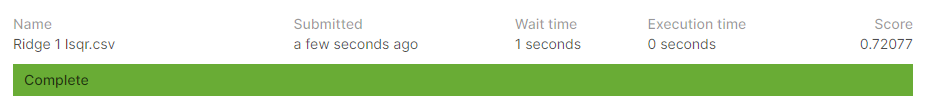

SVM classifier

In [100]:
clf = SVC(random_state=seed, C=1.0, kernel="rbf")
clf.fit(train_vect, train_labels)
predictions = clf.predict(test_vect)

In [101]:
submit("SVM 1 rbf", predictions)

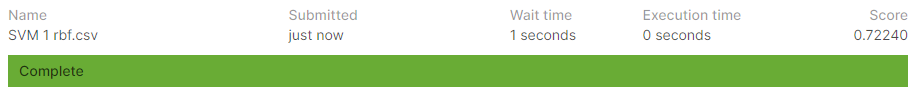

Logistic regression

In [103]:
clf = LogisticRegression(random_state=seed, max_iter=5000, C=10, penalty='l2', solver='liblinear')
clf.fit(train_vect, train_labels)
predictions = clf.predict(test_vect)

In [104]:
submit("Logistic 10 liblinear", predictions)

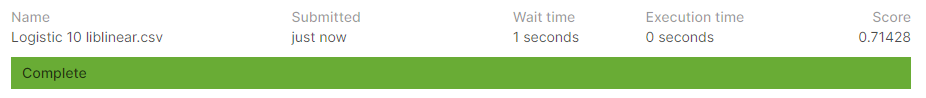

Neural network

In [168]:
torch.manual_seed(seed)

BATCH_SIZE = 300
num_classes = 3
num_epoch = 10

# Создание датасетов
train_ = TensorDataset(torch.tensor(train_vect.astype(np.float32)), 
                       torch.tensor(class_names_to_digits(train_labels).astype(np.float32)))        
train_loader = DataLoader(train_, batch_size=BATCH_SIZE, shuffle=True)

test_ = TensorDataset(torch.tensor(test_vect.astype(np.float32)))        
test_loader = DataLoader(test_, batch_size=BATCH_SIZE, shuffle=False)

input_size = train_vect.shape[1]

# fit 138 
'''
initF = 'xavier_uniform'
optim = 'AdaGrad'
use_dropout = True
use_batchnorm = False
activation = torch.nn.Tanh()
num_layers = 3
hidden_size = 1000
'''

# fit 1086 
#'''
initF = 'kaiming_uniform'
optim = 'AdaGrad'
use_dropout = True
use_batchnorm = False
activation = torch.nn.ReLU()
num_layers = 3
hidden_size = 1000
#'''

# Создание нейронной сети
model = NeuralNetwork(
    input_size=input_size, 
    num_classes=num_classes, 
    hidden_size=hidden_size, 
    activation=activation, 
    num_layers=num_layers, 
    use_dropout=use_dropout, 
    use_batchnorm=use_batchnorm
)

model.to(device)

# Инициализация весов
function = initF    
model.apply(init_weights)  

loss_fn = nn.BCELoss()
learning_rate = 0.001

optimizer = None
if optim == 'Nesterov SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, nesterov = True)
if optim == 'AdaGrad':
    optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
if optim == 'RMSProp':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
if optim == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if optim == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Обучение нейронной сети        
for t in range(num_epoch):
    train_loop(train_loader, model, loss_fn, optimizer)

# Получение предсказаний
predicted_list = []        
with torch.no_grad():
    model.eval()
    for X in test_loader:
        X = X[0].to(device)
        y_pred = model(X)
        predicted_list += y_pred

for i in range(len(predicted_list)):
    predicted_list[i] = predicted_list[i].cpu().numpy().tolist()
    
predicted_list = digits_to_class_names(predicted_list)

In [169]:
submit("Neural Net 138", predicted_list)

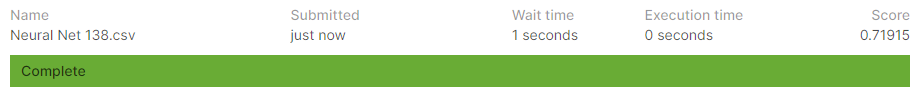

In [ ]:
submit("Neural Net 1086", predicted_list)

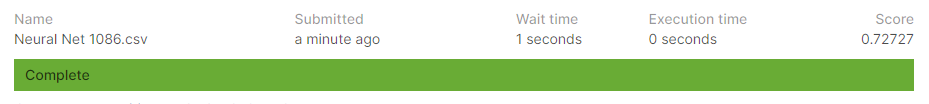

Лучший классификатор по private leaderboard - SVM

private score = 0.71527

6 место на private leaderboad
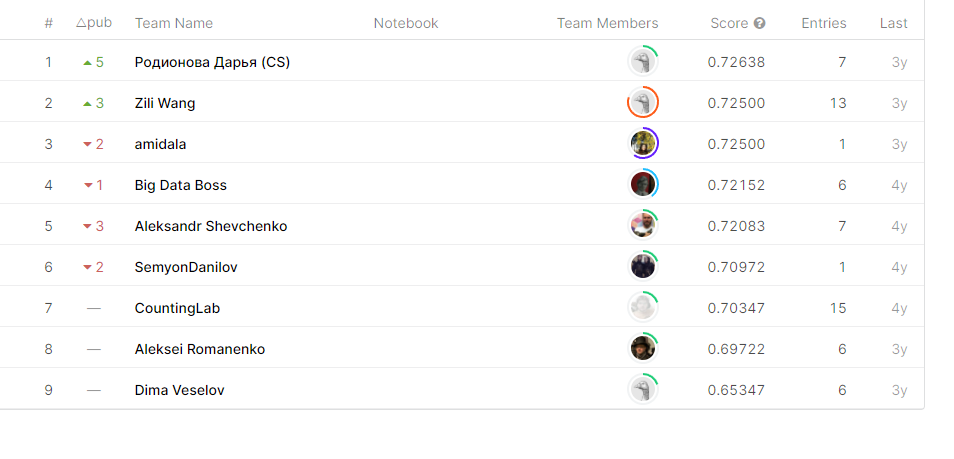

Лучший классификатор по public leaderboard - Neural Net (fit 1086)

public score = 0.72727

6 место на public leaderboard
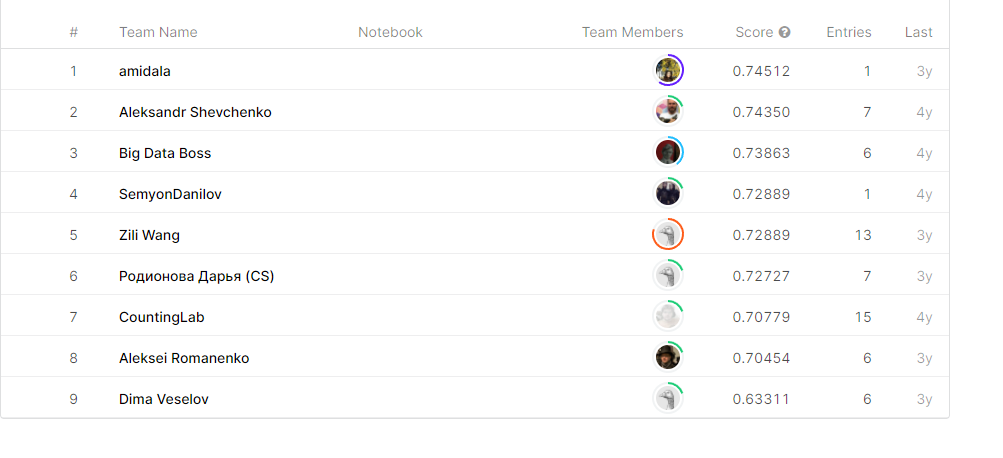

Оценка по отложенной выборке (SVM)

In [171]:
train_labels = [item["sentiment"] for item in train]
clean_texts_train = load_json(clean_texts_train_file)
train_texts, test_texts, train_labels, test_labels = train_test_split(clean_texts_train, train_labels, 
                                                                      random_state = seed, test_size=0.3)

In [172]:
dict_ = make_dict(train_texts, FREQUENCY_LIMIT)
train_vect = create_tfidf_matrix(train_texts, dict_)
test_vect = create_tfidf_matrix(test_texts, dict_)

dictionary generated in 1.09 s
idf calculated in 3.46 s
matrix generated in 15.4 s
matrix normalized in 10.82 s
idf calculated in 1.14 s
matrix generated in 6.66 s
matrix normalized in 4.7 s


In [173]:
clf = SVC(random_state=seed, C=1.0, kernel="rbf")
clf.fit(train_vect, train_labels)
predictions = clf.predict(test_vect)

In [174]:
print(classification_report(test_labels, predictions, digits=3))

              precision    recall  f1-score   support

    negative      0.816     0.561     0.665       435
     neutral      0.703     0.812     0.754      1226
    positive      0.733     0.685     0.708       818

    accuracy                          0.726      2479
   macro avg      0.751     0.686     0.709      2479
weighted avg      0.733     0.726     0.723      2479



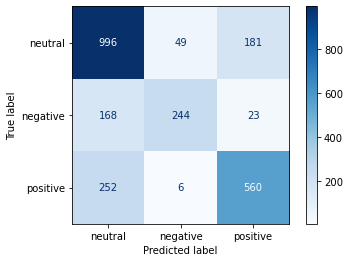

In [175]:
classes = list(set(predictions))
cm = confusion_matrix(test_labels, predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)